In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
# Implementing the Transfer Learning Tutorial
# for computer vision as found @ https://pytorch.org/
# tutorials/beginner/transfer_learning_tutorial.html
# And the TorchVision Instance Segmentation
# Finetuning Turorial as found @ https://colab.research.google.com/
# github/pytorch/tutorials/blob/gh-pages/_downloads/torchvision_finetuning_instance_segmentation.ipynb#scrollTo=cFHKCvCTxiff
# also transformations from https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
# 

In [12]:
import os
import numpy as np
import torchvision
import torch
import torch.utils.data
import torchvision.transforms as T
import torchvision.transforms.functional_pil as f
from PIL import Image
import matplotlib.pyplot as plt


In [13]:
img_dir = "/mnt/chromeos/GoogleDrive/MyDrive/Datasets/models/images/"
target = "/mnt/chromeos/GoogleDrive/MyDrive/Datasets/models/labels.txt"

In [14]:
preprocess = T.Compose([
    T.ToTensor(),
    T.Resize([255, 255]),
    T.Normalize(
         mean=[0.485, 0.456, 0.406], 
         std= [0.229, 0.224, 0.225]
     )
])


class CelebDataset(torch.utils.data.Dataset):
    def __init__(self, root, target):
        self.root = root
        self.imgs = list(sorted(os.listdir(root)))
        
        my_file = open(target, "r")
        data = my_file.read()
        data_into_list = data.split("\n")
        x=list(map(int,data_into_list[:-1]))
        self.target = list(sorted(x))
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.imgs[idx])
        target = self.target[idx]
        img = Image.open(img_path).convert("RGB")
        pre = preprocess(img)
        torch_tar = torch.tensor([target])
        return pre, torch_tar
    
    def __len__(self):
        return len(self.imgs)      

In [15]:
image_datasets = CelebDataset(img_dir, target)
load = torch.utils.data.DataLoader(image_datasets, batch_size=2, shuffle=True)

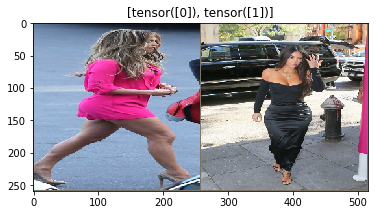

In [16]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(load))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[x for x in classes])

In [17]:
# my_file = open(target, "r")
# data = my_file.read()
# data_into_list = data.split("\n")
# x=list(map(int,data_into_list[:-1]))
# target = list(sorted(x))

In [18]:
# imgs = list(sorted(os.listdir(img_dir)))
# img_path = os.path.join(img_dir, imgs[3])
# img = Image.open(img_path).convert("RGB")
# x=preprocess(img)
# y=x.permute(1,2,0)
# p=y.numpy()
# plt.imshow(p)